# Numerical simulations for "Information Thermodynamics for Deterministic Chemical Reaction Networks" --- light-driven motor

## Loading modules

In [3]:
%matplotlib inline

# Modules
import math 
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import *
import scipy.integrate as integrate
from scipy.integrate import quad


print(matplotlib.__version__)

3.3.4


## Parameters (physical constants, experimental setup, photochemical parameters, kinetic rate constants)

### Reference experiments: Nat. Nanotechnol. 10, 70-75 (2015)

### Data from:  Nat. Nanotechnol. 10, 70-75 (2015), Angew. Chem. Int. Ed. 131, 14479-14486 (2019)

In [4]:
# Constants

pi     = 3.14159265359
h      = 6.62607004e-34 # [J*s]
hbar   = h/(2*pi)
kb     = 1.38064852e-23   # [J/K]
c      = 299792458        # [m/s]
Na     = 6.02214086e23
R      = kb*Na
T      = 298

C_kJ   = 4184 # 1kCal = 4184 J

# Experimental geometry

Vol    = 3e-3           # [L] = 3mL
b      = 1e-2           # [m] = 1cm


#Photochemical parameters (E,Z,EA,ZA)

epsilon365 = np.array([780000,17000,1050000,5500])
epsilon436 = np.array([67000,170000,67000,170000])
phi365 = np.array([0.15,0.29,0.15,0.29])
phi436 = np.array([0.30,0.62,0.30,0.62])

#non-radiative thermal kinetic constants

kp1a = 54; km1a = 8.6e-5
kp1c = 0.81; km1c = km1a*kp1c/kp1a

kp2 = 1e-16; km2 = 1.3e-6;

kp3c = 4.7e-6; km3c = 0.81;
km3a = 0.01; kp3a = km3a*kp3c/km3c;

kp4 = 1.4e-6; km4 = kp1a*kp2*kp3c*kp4/(km1a*km2*km3c);


2477.709039945977


## Functions for computations

In [5]:
# SS_solution returns the bright steady state

def photokinetics(lo):
    """
    Takes a value of wavelength in meters as input and returns corresponding kinetic parameters to be used by brightSS().
    """
    
    if lo==365e-9: 
        c2p = 0.15*1050000*b*np.log(10)/Vol #YE, E_AE
        c2m = 0.29*5500*b*np.log(10)/Vol #YZ, E_AZ   
        c4p = 0.29*17000*b*np.log(10)/Vol #YZ, E_Z
        c4m = 0.15*780000*b*np.log(10)/Vol #YE, E_E
        
    
    elif lo==436e-9:
        c2p = 0.30*67000*b*np.log(10)/Vol #YE, E_AE
        c2m = 0.62*170000*b*np.log(10)/Vol #YZ, E_AZ   
        c4p = 0.62*170000*b*np.log(10)/Vol #YZ, E_Z
        c4m = 0.30*67000*b*np.log(10)/Vol #YE, E_E
        
    else: print('No data for wavelength ', lo)

    return c2p,c2m,c4p,c4m

def brightSS(z,A0,F0,FF,lo):
    """
    Input: guessed steady state concentrations, total concentrations of ring and axle, photon flux, wavelength.
    Output: steady state solution.
    """
    
    CP2, CM2, CP4, CM4 = photokinetics(lo)    
        
    A  = z[0]
    E  = z[1]
    Z  = z[2]
    AE = z[3]
    AZ = z[4]

    F = np.empty((5))
    F[0] = (-(kp4 + FF*CP4)*Z - (km3a + km3c)*A*Z
            + (kp3a + kp3c)*AZ + (km4 + FF*CM4)*E) #dt Z
    F[1] = (- (kp2 + FF*CP2)*AE - (km1a + km1c)*AE
            + (kp1a + kp1c)*A*E + (km2 + FF*CM2)*AZ) #dt AE
    F[2] = (- (km2 + FF*CM2)*AZ - (kp3a + kp3c)*AZ
            + (kp2 + FF*CP2)*AE + (km3a + km3c)*A*Z) #dt AZ
    F[3] = F0 - E - Z - AE - AZ
    F[4] = A0 -A -AE -AZ
    return F


def absucurr(ss,FF,lo):
    """
    Input: steady state concentrations, photon flow, wavelength
    Output: photons absorbed per unit time and volume leading to photoisomerizations
    """
    CP2, CM2, CP4, CM4 = photokinetics(lo)
    abscurr = FF*CM4*ss[1] + FF*CP4*ss[2] + FF*CP2*ss[3] + FF*CM2*ss[4]
    return abscurr

#Various thermodynamics quantities:

def nph(r,flux,conc,Epsilon):
    prefactor = flux*b/(c*Vol) #the flux is in units of einstein/s on the whole surface
    A = np.dot(Epsilon,conc)
    #return prefactor*(1 - np.log(10)*A*r)
    return prefactor*10**(-r*A)

def planck(ll,T):
    prefactor = 8*pi/(Na*ll**4)
    expo = h*c/(kb*ll*T)
    return prefactor/(np.exp(expo)-1)

def Pnumber(T,r,flux,conc,Epsilon):
    lo1 = lo - 5e-9
    lo2 = lo + 5e-9
    return quad(planck, lo1, lo2,args=(T))[0] - nph(r,flux,conc,Epsilon)
    
def Tbb(r,flux,conc,Epsilon): 
    return fsolve(Pnumber,10000,args=(r,flux,conc,Epsilon))[0]

def etaC(r,flux,conc,Epsilon):
    return 1-T/Tbb(r,flux,conc,Epsilon)

def muph(r,flux,conc,Epsilon):
    prefactor = Na*h*c/lo
    return prefactor*etaC(r,flux,conc,Epsilon)

# Steady state solution for different forces and related thermodynamic quantities

In [6]:
A0 = 50e-6
F0 = 150e-6
lo = 365e-9; FF_exp = 1.67e-9; EPS = epsilon365 #uncomment for Figure 2b
#lo = 436e-9; FF_exp = 4e-9; EPS = epsilon436   #uncomment for Figure 2c

PHFLUX = [] ; CURRENT = []; NNU = []
INFOFLOW = []; EFLOW = []; DISS = []; INTEFF = []; EPSA = []
CHEMPOT = []; TEMP = []; CHEMPOTTH = []

ssGuess = np.array([1e-4,1e-4,1e-4,1e-4,1e-4])
eqGuess = np.array([1e-5,1e-5,1e-5,1e-5,1e-5])

# Experimental values:
ss_exp = fsolve(brightSS, ssGuess, args=(A0,F0,FF_exp,lo)) 
I_exp = quad(muph, 0, b, args=(FF_exp,[ss_exp[1],ss_exp[2],ss_exp[3],ss_exp[4]],EPS))
mu_exp = I_exp[0]/b

# Varying photon flow

for FF in np.geomspace(1e-15,1e-5,100):
        
    ss = fsolve(brightSS, ssGuess, args=(A0,F0,FF,lo)) 
    ssGuess = np.array([ss[0],ss[1],ss[2],ss[3],ss[4]])
    jss = (ss[0]*ss[1]*kp1a - ss[3]*km1a) + (ss[0]*ss[1]*kp1c - ss[3]*km1c)
    inu = absucurr(ss,FF,lo)
    
    
    I = quad(muph, 0, b, args=(FF,[ss[1],ss[2],ss[3],ss[4]],EPS))
    mu_av = I[0]/b
    
    eflow = jss*(np.log(kp1a/km1a) + np.log(kp3c/km3c))*(R*T)
    iflow = jss*np.log((ss[1]*ss[4])/(ss[2]*ss[3]))*(R*T)
    eff = (eflow+iflow)/(inu*mu_av)
    
    CURRENT.append(jss)
    CHEMPOT.append(mu_av/T)
    PHFLUX.append(FF)
    EFLOW.append(eflow/1000)
    INFOFLOW.append(iflow/1000)
    EPSA.append((eflow+iflow)/1000)
    INTEFF.append(eff*100)

# Generating plots for Figure 2

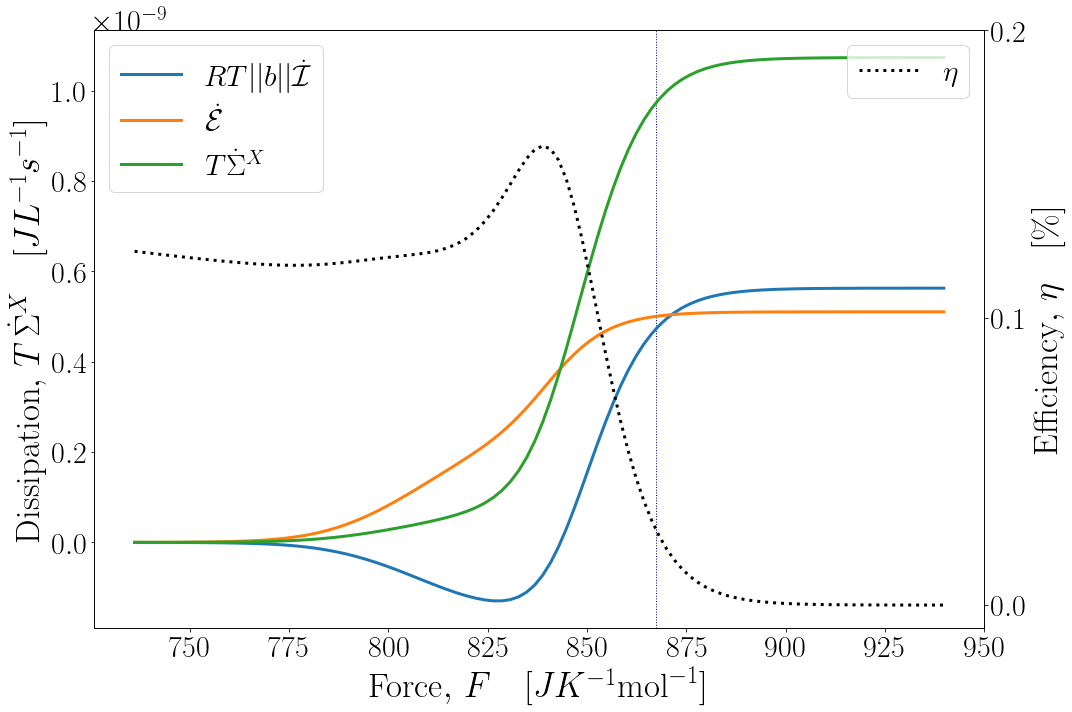

In [7]:
#Plot info eflow

infothermo, ax1 = plt.subplots(1,figsize=(15,10))
ax1.axvline(x=mu_exp/T, linewidth=1.0, color='darkblue', linestyle=':')
ax1.plot(CHEMPOT, INFOFLOW , linewidth=3.0, linestyle='solid', label='$RT|| b ||\dot{\mathcal{I}}$')
ax1.plot(CHEMPOT, EFLOW , linewidth=3.0, linestyle='solid', label='$\dot{\mathcal{E}}$')
ax1.plot(CHEMPOT, EPSA , linewidth=3.0, linestyle='solid', label='$T\dot{\Sigma}^X$')
ax1.set_xlabel('$\mathrm{Force}, \, F \quad [J K^{-1}\mathrm{mol}^{-1}]$', size = 35)
ax1.set_ylabel('$\mathrm{Dissipation}, \, T\, \dot{\Sigma}^X \quad [J L^{-1} s^{-1}]$', size = 35)
ax1.tick_params('y', labelsize=30)
ax1.yaxis.get_offset_text().set_fontsize(30)


ax2 = ax1.twinx()
ax2.plot(CHEMPOT, INTEFF , linewidth=3.0, linestyle=':',c='black',label='$\\eta$')
ax2.set_yticks([0,0.1,0.2])
ax2.tick_params('y', labelsize=30)
ax2.set_ylabel('$\mathrm{Efficiency}, \, \\eta \quad [\\%] $', size = 35)


#settings
ax1.tick_params('y', labelsize=30)
ax1.tick_params('x', labelsize=30)
#ax1.set_yscale('log')



ax1.legend(loc=0, prop={'size': 30})
ax2.legend(loc=1, prop={'size': 30})

infothermo.tight_layout()

plt.show()